In [96]:
# Librerias utilizadas en los codigos

from statsbombpy import sb
import pandas as pd
from mplsoccer import VerticalPitch,Pitch
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from matplotlib.patches import Rectangle, FancyBboxPatch, Circle, FancyArrowPatch
from collections import Counter
import textwrap
import os
import base64
import requests
from io import BytesIO
from dotenv import load_dotenv
from IPython.display import Image, display
from matplotlib.cm import get_cmap
from textwrap import fill
from sklearn.cluster import KMeans
from matplotlib.patches import Rectangle, FancyBboxPatch, FancyArrowPatch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from pathlib import Path
from matplotlib.path import Path as MplPath
import matplotlib.image as mpimg

In [97]:
# Cargar los archivos necesarios
input_path = Path("../data") / "database_v5.csv"
df = pd.read_csv(input_path, low_memory=False)

In [98]:
# Cargar clave API desde .env
ruta_env = Path("../env") / "TFM_Tactics.env"
load_dotenv(dotenv_path=ruta_env)

api_key = os.getenv("OPENAI_API_KEY")

In [99]:
# Generar prompt para jugadas individuales (shots, passes, carries)
def prompt_freeze(jugada):
    import pandas as pd

    def existe_y_valida(var):
        try:
            val = jugada.iloc[0][var]
            if isinstance(val, (list, dict)):
                return True
            return not pd.isna(val)
        except:
            return False

    def parse_location(var):
        try:
            val = jugada[var].values[0]
            if isinstance(val, str):
                val = eval(val)
            if isinstance(val, (list, tuple)) and len(val) >= 2 and all(isinstance(i, (int, float)) for i in val[:2]):
                return val[0], val[1]
        except:
            pass
        return None, None

    def detectar_estilo_ataque(freeze):
        if not isinstance(freeze, list) or len(freeze) < 2:
            return "Sin información suficiente para determinar el tipo de ataque"

        n_team = sum(p.get('teammate', False) for p in freeze)
        n_rival = sum(not p.get('teammate', False) for p in freeze)
        ubicaciones = [p.get('location', [None, None]) for p in freeze if isinstance(p.get('location'), list)]
        xs = [x for x, y in ubicaciones if x is not None]
        ys = [y for x, y in ubicaciones if y is not None]

        if not xs or not ys:
            return "Datos posicionales insuficientes"

        ancho = max(ys) - min(ys)
        profundidad = max(xs) - min(xs)
        centro = sum(ys) / len(ys)

        if n_team <= 2 and n_rival <= 2:
            return "Contraataque"
        elif n_team >= 5 and n_rival >= 5 and profundidad < 35:
            return "Juego posicional"
        elif profundidad > 50 and ancho < 25:
            return "Ataque directo"
        elif ancho >= 40 and centro > 55:
            return "Ataque por banda derecha"
        elif ancho >= 40 and centro < 25:
            return "Ataque por banda izquierda"
        elif 30 <= centro <= 50:
            return "Ataque por carriles interiores"
        elif n_team > n_rival + 1:
            return "Ataque en superioridad numérica"
        elif n_rival > n_team + 1:
            return "Ataque en inferioridad numérica"
        elif 3 <= n_team <= 4 and 3 <= n_rival <= 4:
            return "Transición ofensiva"
        else:
            return "Ataque mixto o situación ambigua"

    get_val = lambda var: jugada[var].values[0] if existe_y_valida(var) else None

    minuto = get_val('minute')
    segundo = get_val('second')
    jugador = get_val('player')
    equipo = get_val('team')
    equipo_posesion = get_val('possession_team')
    tipo = get_val('type')
    x0, y0 = parse_location('location')
    x1, y1 = parse_location('pass_end_location')
    carry_x, carry_y = parse_location('carry_end_location')
    duracion = get_val('duration')
    marcador = f"{get_val('home_score')} - {get_val('away_score')}"
    tipo_pase = get_val('pass_height')
    angulo = get_val('pass_angle')
    longitud = get_val('pass_length')
    receptor = get_val('pass_recipient')
    body_part = get_val('pass_body_part')
    patron = get_val('play_pattern')
    presion = get_val('under_pressure')
    vis = get_val('visible_area')
    freeze = get_val('freeze_frame')
    n_team = sum(p.get('teammate', False) for p in freeze) if isinstance(freeze, list) else '?'
    n_rival = sum(not p.get('teammate', False) for p in freeze) if isinstance(freeze, list) else '?'

    home_team = get_val('home_team')
    away_team = get_val('away_team')
    home_score = get_val('home_score')
    away_score = get_val('away_score')
    resultado_final = f"Resultado del partido: {home_team} {home_score} - {away_score} {away_team}"

    if tipo == "Shot" and get_val('shot_outcome') == 'Goal':
        xg = get_val('shot_statsbomb_xg')
        if xg is not None:
            nivel = "alta" if xg > 0.5 else "moderada" if xg > 0.2 else "baja"
            gol_info = f"\n\nGol de {jugador} con un xG de {xg:.2f} ({nivel} probabilidad)"
        else:
            gol_info = f"\n\nGol de {jugador}"
    else:
        gol_info = ""

    enfoque = "atacante" if equipo_posesion == "Bayer Leverkusen" else "defensivo" if equipo == "Bayer Leverkusen" else "neutral"
    estilo = detectar_estilo_ataque(freeze)

    descripcion = f"Minuto {minuto}:{segundo:02d} - {jugador} ({equipo}) ejecuta un {tipo.lower()}"
    secciones = [
        f"Desde ({x0:.1f}, {y0:.1f}) hacia ({x1:.1f}, {y1:.1f})." if x0 and x1 else "",
        f"Conducción hasta ({carry_x:.1f}, {carry_y:.1f})." if carry_x else "",
        f"Duración: {duracion:.2f} s." if duracion else "",
        f"Pase: Altura={tipo_pase}, Longitud={longitud:.1f} m, Ángulo={angulo:.2f} rad." if longitud and angulo else "",
        f"Parte del cuerpo: {body_part}, Receptor: {receptor}" if body_part or receptor else "",
        f"Tipo: {tipo}, Patrón: {patron}" if tipo or patron else "",
        f"¿Bajo presión?: {'Sí' if presion else 'No'}" if presion is not None else "",
        f"Jugadores visibles: {n_team} compañeros, {n_rival} rivales.",
        f"Área visible parcial: {'Sí' if vis else 'No'}" if vis is not None else "",
        f"Marcador parcial: {marcador}",
        resultado_final,
        gol_info
    ]

    jugadores_vistos = ""
    if isinstance(freeze, list):
        jugadores_vistos = "\n" + "\n".join([
            f"Jugador {i+1} ({'compañero' if p.get('teammate') else 'rival'}) en ({p['location'][0]:.1f}, {p['location'][1]:.1f})"
            for i, p in enumerate(freeze) if p.get("location")
        ])

    prompt = f"""Analiza la imagen adjunta junto con los datos siguientes:

Estilo de ataque: {estilo}.

{descripcion}
""" + "\n".join(filter(None, secciones)) + jugadores_vistos + f"""


Analiza esta acción desde un punto de vista táctico {enfoque} y siempre desde el punto d vi. Evalúa si la decisión fue adecuada y propón alternativas más efectivas. No incluyas coordenadas literales.

Responde con:
1. Cuatro claves tácticas numeradas.
2. Una conclusión táctica breve (3 líneas).
"""
    return prompt

# Generar imagen base64 para cada jugada
def imagen_base64_freeze(
    df,
    match_id,
    equipo="Bayer Leverkusen",
    index=0,
    tipo_jugada="Offensive",
    evento="Pass",
    exitoso=None,
    tipo_fase_juego=None,
    texto_ia="[Análisis táctico IA pendiente]",
    modelo="gpt-4o"
):
    fig = grafico_freeze(
        df=df,
        match_id=match_id,
        equipo=equipo,
        index=index,
        tipo_jugada=tipo_jugada,
        evento=evento,
        exitoso=exitoso,
        tipo_fase_juego=tipo_fase_juego,
        modelo=modelo,
        texto_ia=texto_ia
    )
    buf = BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', dpi=150)
    plt.close(fig)
    return base64.b64encode(buf.getvalue()).decode('utf-8')

# Enviar imagen + prompt a la API de OpenAI
def analizar_freeze(base64_image, prompt, modelo="gpt-4o"):
    url = "https://api.openai.com/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }
    body = {
        "model": modelo,
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{base64_image}"}},
                    {"type": "text", "text": prompt}
                ]
            }
        ],
        "temperature": 0.7
    }
    response = requests.post(url, headers=headers, json=body)
    if response.status_code == 200:
        return response.json()["choices"][0]["message"]["content"]
    else:
        raise Exception(f"Error: {response.status_code} - {response.text}")

In [100]:
def grafico_freeze(df, match_id, equipo, index=0,
                              tipo_jugada='Offensive',
                              evento='Pass',
                              exitoso=None,
                              tipo_fase_juego=None,
                              tipo_reanudacion=None,
                              texto_ia="[Análisis no disponible]",
                              figsize=(16, 10),
                              modelo="gpt-4o",
                              logo_path=Path("../logos/Bundesliga.png")):

    eventos_validos = ['Pass', 'Carry', 'Shot']
    if evento not in eventos_validos:
        print(f"[AVISO] El evento '{evento}' no está soportado para análisis. Solo se permiten: {eventos_validos}.")
        return None, None
 
    info = df[df['match_id'] == match_id].dropna(subset=['home_team', 'away_team', 'home_score', 'away_score', 'match_date']).iloc[0]
    
    # Filtrar eventos según todos los filtros
    df_freeze = df[
        (df['match_id'] == match_id) &
        (df['team'] == equipo) &
        (df['event_type'] == evento) &
        (df['type_category'] == tipo_jugada)
    ].copy()

    if exitoso is not None:
        df_freeze = df_freeze[df_freeze['exitoso'] == exitoso].copy()

    if tipo_fase_juego is not None:
        df_freeze = df_freeze[df_freeze['play_pattern'] == tipo_fase_juego].copy()

    df_freeze.reset_index(drop=True, inplace=True)

    if df_freeze.empty or index >= len(df_freeze):
        print("No se encontraron eventos que coincidan con los filtros seleccionados.")
        return None, None

    def convertir_a_lista(x):
        if isinstance(x, str):
            return eval(x)
        return x

    df_freeze['location'] = df_freeze['location'].apply(convertir_a_lista)

    if evento == 'Pass':
        df_freeze['end_location'] = df_freeze['pass_end_location'].apply(convertir_a_lista)
    elif evento == 'Carry':
        df_freeze['end_location'] = df_freeze['carry_end_location'].apply(convertir_a_lista)
    elif evento == 'Shot':
        df_freeze['end_location'] = df_freeze['shot_end_location'].apply(convertir_a_lista)

    if evento in ['Pass', 'Carry', 'Shot']:
        df_freeze['end_location'] = df_freeze['end_location'].apply(lambda x: x[:2] if isinstance(x, list) and len(x) >= 2 else None)
        df_freeze = df_freeze[df_freeze['end_location'].notna()].copy()
        df_freeze[['x_end', 'y_end']] = pd.DataFrame(df_freeze['end_location'].tolist(), index=df_freeze.index)

    df_freeze['freeze_frame'] = df_freeze['freeze_frame'].apply(convertir_a_lista)
    df_freeze['visible_area'] = df_freeze['visible_area'].apply(convertir_a_lista)
    df_freeze[['x_start', 'y_start']] = pd.DataFrame(df_freeze['location'].tolist(), index=df_freeze.index)

    jugada = df_freeze.iloc[[index]]

    if 'duration' not in jugada.columns:
        jugada['duration'] = 0.0
    
    x0, y0 = jugada['x_start'].iloc[0], jugada['y_start'].iloc[0]
    x1, y1 = jugada['x_end'].iloc[0], jugada['y_end'].iloc[0] if evento in ['Pass', 'Carry', 'Shot'] else (None, None)
    freeze = jugada['freeze_frame'].iloc[0]
    vis_area = jugada['visible_area'].iloc[0]

    exitoso = bool(jugada['exitoso'].iloc[0])
    color_evento = 'green' if exitoso else 'red'

    actor_nombre = next(
        (jugada['player'].values[0] for p in freeze if p.get("actor", False)),
        jugada['player'].values[0]
    )

    receptor_nombre = None
    if evento == "Pass" and pd.notna(jugada['pass_recipient'].values[0]):
        recipient = jugada['pass_recipient'].values[0]
        if isinstance(recipient, dict):
            receptor_nombre = recipient.get('name')

    fig = plt.figure(figsize=figsize, facecolor='white')
    gs = fig.add_gridspec(3, 3, width_ratios=[3, 0.1, 1.2], height_ratios=[4, 1.9, 0.2])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0:2, 2])
    ax3 = fig.add_subplot(gs[1, 0])

    bg_ax = fig.add_axes([0, 0, 1, 1], zorder=-1)
    bg_ax.axis("off")
    bg_ax.add_patch(FancyBboxPatch((0, 0), 1, 1, transform=fig.transFigure,
                                   boxstyle="round,pad=0.01", facecolor='white',
                                   edgecolor="black", linewidth=1.5, zorder=-1))

    ax1.set_facecolor('white')
    ax1.add_patch(Rectangle((0, 0), 120, 80, facecolor='#d9d9d9', zorder=0))

    if isinstance(vis_area, list) and len(vis_area) >= 6:
        coords = [(vis_area[i], vis_area[i + 1]) for i in range(0, len(vis_area) - 1, 2)]
        ax1.add_patch(plt.Polygon(coords, color='white', zorder=1))

    pitch = Pitch(pitch_type='statsbomb', pitch_color=None, line_color='black', linewidth=1)
    pitch.draw(ax=ax1)
    for el in ax1.findobj():
        try: el.set_zorder(2.5)
        except: continue

    pitch.scatter(x0, y0, ax=ax1, c='black', s=100, edgecolors='black', zorder=3)

    if pd.notna(x1) and pd.notna(y1):
        try:
            if evento == 'Shot':
                # Curva para disparo
                distancia = ((x1 - x0) ** 2 + (y1 - y0) ** 2) ** 0.5
                altura_curva = min(15, distancia * 0.3)
                dy = -altura_curva if y1 < y0 else altura_curva
                verts = [(x0, y0), ((x0 + x1) / 2, (y0 + y1) / 2 + dy), (x1, y1)]
                codes = [MplPath.MOVETO, MplPath.CURVE3, MplPath.CURVE3]
                path = MplPath(verts, codes)
                patch = FancyArrowPatch(path=path, color=color_evento, lw=2,
                                        arrowstyle='-|>', mutation_scale=12, zorder=3)
                ax1.add_patch(patch)
    
            elif evento in ['Pass', 'Carry']:
                # Línea con estela
                pitch.lines(x0, y0, x1, y1, ax=ax1, comet=True, color=color_evento, lw=2, zorder=3)
    
            else:
                # Cualquier otro tipo de jugada con coordenadas: línea básica
                ax1.plot([x0, x1], [y0, y1], color=color_evento, linewidth=2, zorder=3)
    
        except Exception as e:
            print("Error al trazar el evento:", e)

    for idx, player in enumerate(freeze):
        loc = player['location']
        is_actor = player.get("actor", False)
        is_teammate = player.get("teammate", False)
        is_keeper = player.get("keeper", False)

        color = 'red' if is_teammate else 'darkblue'
        marker = 'D' if is_keeper else 'o'
        size = 400 if is_actor else 300
        edge_width = 3 if is_actor else 1.5
        edge_color = 'gold' if is_actor else 'black'

        ax1.scatter(loc[0], loc[1], c=color, s=size, marker=marker,
                    edgecolors=edge_color, linewidths=edge_width, zorder=4)
        ax1.text(loc[0], loc[1], str(idx + 1), color='white', fontsize=9,
                 ha='center', va='center', zorder=5, weight='bold' if is_actor else 'normal')

    ax1.set_xlim(0, 120)
    ax1.set_ylim(80, 0)
    ax1.axis('off')

    # PANEL DE DATOS
    ax2.set_facecolor("white")
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.axis("off")
    
    home_team = jugada['home_team'].values[0]
    away_team = jugada['away_team'].values[0]
    minuto = int(jugada['minute'].values[0])
    segundo = int(jugada['second'].values[0])

    if minuto > 90:
        texto_periodo = "Final del partido"
    elif minuto > 45:
        texto_periodo = "Segunda mitad"
    else:
        texto_periodo = "Primera mitad"

    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.text(0.5, 0.95, str(jugada['match_date'].values[0]), ha="center", fontsize=10, weight='bold')
    ax2.text(0.5, 0.91, texto_periodo, ha="center", fontsize=10)
    ax2.text(0.5, 0.88, f"{minuto}:{segundo:02d}", ha="center", fontsize=22, weight='bold')

    df_parcial = df[(df['match_id'] == match_id) &
                (df['minute'] < minuto) |
                ((df['minute'] == minuto) & (df['second'] <= segundo))]

    goles_local = df_parcial[(df_parcial['type'] == 'Shot') &
                             (df_parcial['shot_outcome'] == 'Goal') &
                             (df_parcial['team'] == home_team)].shape[0]
    
    goles_visitante = df_parcial[(df_parcial['type'] == 'Shot') &
                                 (df_parcial['shot_outcome'] == 'Goal') &
                                 (df_parcial['team'] == away_team)].shape[0]

    ax2.add_patch(Rectangle((0.35, 0.82), 0.1, 0.05, color='black'))
    ax2.add_patch(Rectangle((0.55, 0.82), 0.1, 0.05, color='black'))
    ax2.text(0.4, 0.845, str(goles_local), color='white', ha='center', va='center', fontsize=16)
    ax2.text(0.6, 0.845, str(goles_visitante), color='white', ha='center', va='center', fontsize=16)
    color_home = "red" if home_team == "Bayer Leverkusen" else "blue"
    color_away = "red" if away_team == "Bayer Leverkusen" else "blue"
    ax2.text(0.01, 0.81, '\n'.join(textwrap.wrap(home_team, width=15)), color=color_home, fontsize=10, ha="left", weight="bold")
    ax2.text(0.99, 0.81, '\n'.join(textwrap.wrap(away_team, width=15)), color=color_away, fontsize=10, ha="right", weight="bold")


    datos_evento = [
        ("Event Type", jugada['type'].values[0]),
        ("Play Type", jugada['play_pattern'].values[0]),
        ("Actor", actor_nombre),
    ]
    if receptor_nombre:
        datos_evento.append(("Receptor", receptor_nombre))

    datos_evento += [
        ("Outcome", "Success" if exitoso else "Failure"),
        ("Category", jugada['type_category'].values[0]),
        (f"{home_team} Visible", sum(p.get("teammate", False) for p in freeze)),
        (f"{away_team} Visible", sum(not p.get("teammate", False) for p in freeze)),
        ("Duration", f"{jugada['duration'].values[0]:.2f}s")
    ]

    y_start = 0.72
    row_height = 0.045
    for i, (label, value) in enumerate(datos_evento):
        y = y_start - i * row_height
        color_row = '#f2f2f2' if i % 2 == 0 else 'white'
        ax2.add_patch(Rectangle((0, y - 0.03), 1, 0.045, color=color_row, transform=ax2.transAxes, zorder=0))
        ax2.text(0.02, y, f"{label}:", fontsize=8, weight="bold", ha="left")
        ax2.text(0.98, y, str(value), fontsize=8, ha="right")

    ax2.hlines(0.04, xmin=0.02, xmax=0.98, colors='gray', linestyles='dotted', linewidth=0.8)
    ax2.text(0.02, 0.02, "Success", fontsize=8, color='green', weight='bold', ha='left', va='bottom')
    ax2.text(0.32, 0.02, "Failure", fontsize=8, color='red', weight='bold', ha='left', va='bottom')

    lineas = texto_ia.splitlines()
    texto_ia = "\n".join([fill(line.strip(), width=110) for line in lineas])
    texto_ia = texto_ia.replace("**", "")
    
    ax3.set_facecolor("lightgrey")
    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 1)
    ax3.axis("off")
    ax3.add_patch(Rectangle((0, 0), 1, 1, transform=ax3.transAxes, color="lightgrey",
                            zorder=0, linewidth=1.2, edgecolor="black"))
    ax3.text(0.05, 0.92, "Análisis táctico IA", fontsize=10, weight="bold", va="top")
    ax3.text(0.05, 0.82, texto_ia, fontsize=8, va="top", ha="left", linespacing=1, wrap=True, family="monospace")

    logo = mpimg.imread(logo_path)
    imagebox = OffsetImage(logo, zoom=0.15)
    ab = AnnotationBbox(imagebox, (0.97, 0.05), frameon=False, xycoords='figure fraction', box_alignment=(1, 0))
    fig.add_artist(ab)

    fig.subplots_adjust(wspace=0.03, hspace=0.001, top=0.98, bottom=0.02)

    return fig

In [101]:
def analisis_freeze_completo(
    df,
    match_id,
    equipo="Bayer Leverkusen",
    index=0,
    tipo_jugada="Offensive",
    evento="Pass",
    exitoso=None,
    tipo_fase_juego=None,
    modelo="gpt-4o"
):
    # Paso 1: Filtrar jugada válida
    df_filtered = df[
        (df['match_id'] == match_id) &
        (df['team'] == equipo) &
        (df['event_type'] == evento) &
        (df['type_category'] == tipo_jugada)
    ]
    if exitoso is not None:
        df_filtered = df_filtered[df_filtered['exitoso'] == exitoso]
    if tipo_fase_juego is not None:
        df_filtered = df_filtered[df_filtered['play_pattern'] == tipo_fase_juego]

    df_filtered = df_filtered.reset_index(drop=True)

    if df_filtered.empty or index >= len(df_filtered):
        raise ValueError("No se encontró una jugada que coincida con los filtros proporcionados.")

    # Extraer jugada y generar prompt
    jugada = df_filtered.iloc[[index]]

    # Generar imagen base64 con panel IA
    texto_ia_temp = "[Análisis táctico IA pendiente]"
    fig_temp = imagen_base64_freeze(
        df=df,
        match_id=match_id,
        equipo=equipo,
        index=index,
        tipo_jugada=tipo_jugada,
        evento=evento,
        exitoso=exitoso,
        tipo_fase_juego=tipo_fase_juego,
        modelo=modelo,
        texto_ia="[Análisis táctico IA pendiente]"
    )

    # Generar prompt para clustering
    prompt = prompt_freeze(jugada)

    #Enviar a GPT-4o y recibir análisis
    texto_ia = analizar_freeze(
        base64_image=fig_temp,
        prompt=prompt
    )

    #Análisis IA
    fig = grafico_freeze(
        df=df,
        match_id=match_id,
        equipo=equipo,
        index=index,
        tipo_jugada=tipo_jugada,
        evento=evento,
        exitoso=exitoso,
        tipo_fase_juego=tipo_fase_juego,
        modelo=modelo,
        texto_ia=texto_ia
    )

    return fig, texto_ia, prompt

Analiza la imagen adjunta junto con los datos siguientes:

Estilo de ataque: Sin información suficiente para determinar el tipo de ataque.

Minuto 23:04 - Jeremie Frimpong (Bayer Leverkusen) ejecuta un shot
Duración: 0.31 s.
Tipo: Shot, Patrón: Regular Play
Jugadores visibles: ? compañeros, ? rivales.
Área visible parcial: Sí
Marcador parcial: 3 - 2
Resultado del partido: Bayer Leverkusen 3 - 2 RB Leipzig


Gol de Jeremie Frimpong con un xG de 0.49 (moderada probabilidad)


Analiza esta acción desde un punto de vista táctico atacante y siempre desde el punto d vi. Evalúa si la decisión fue adecuada y propón alternativas más efectivas. No incluyas coordenadas literales.

Responde con:
1. Cuatro claves tácticas numeradas.
2. Una conclusión táctica breve (3 líneas).



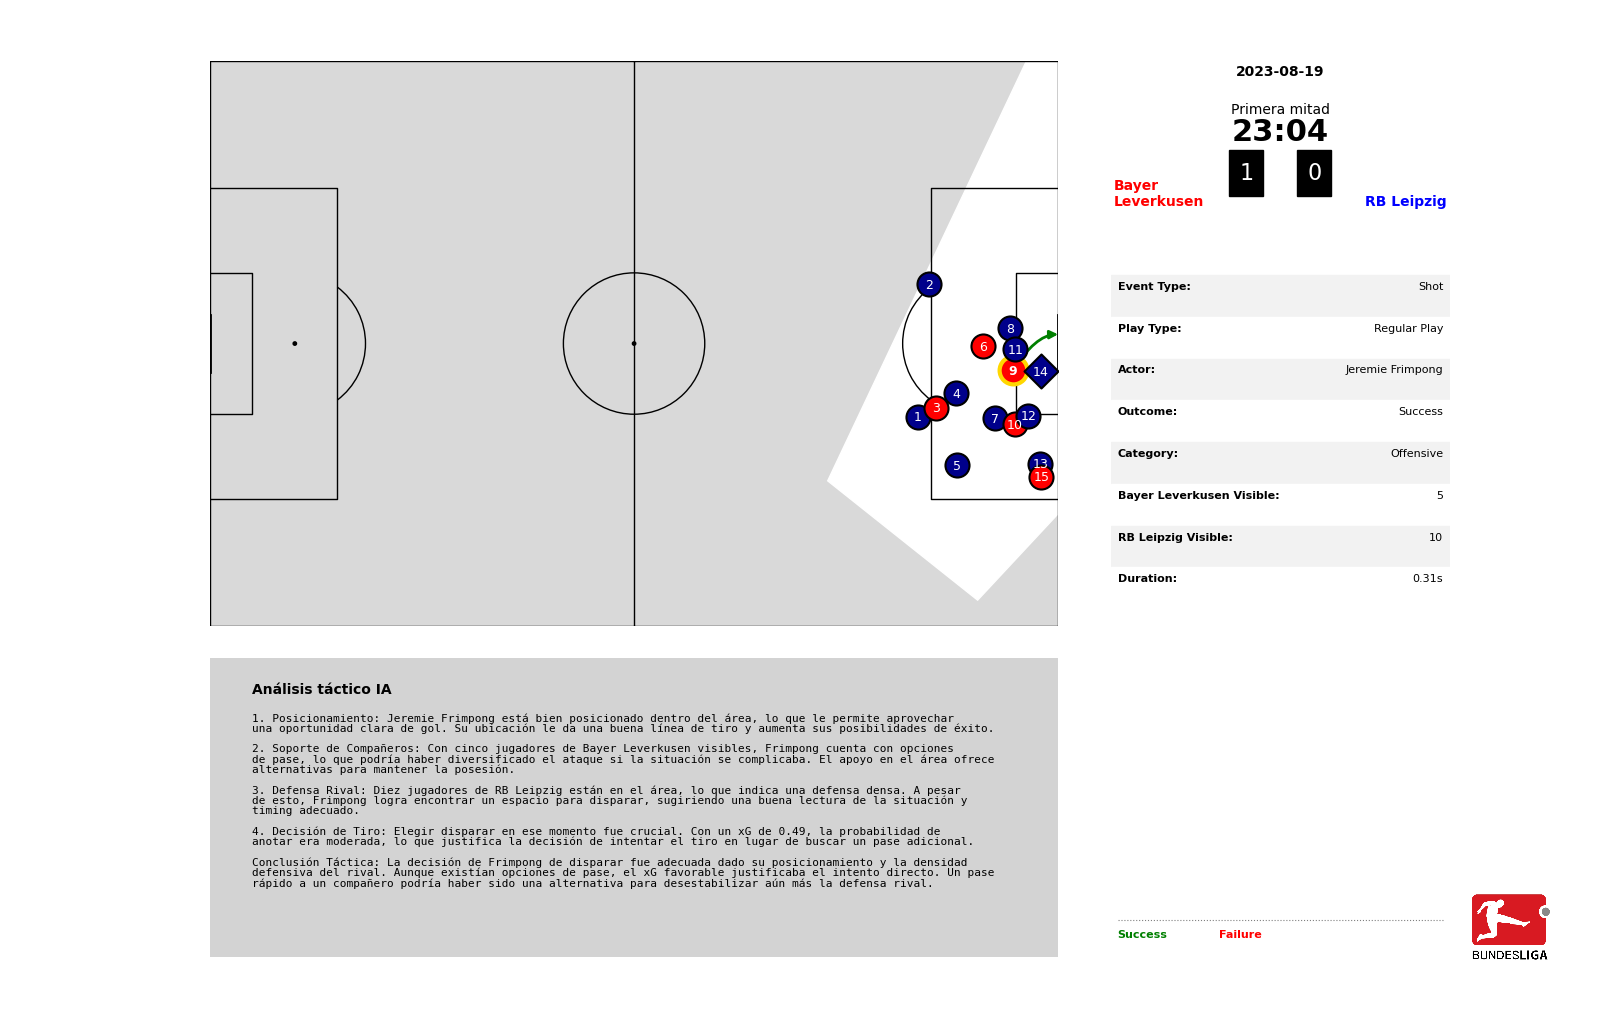

In [102]:
match_id=3895052
equipo="Bayer Leverkusen"
evento="Shot"
tipo_jugada="Offensive"
exitoso=True
tipo_fase_juego="Regular Play" 
index=0

fig, texto_ia, prompt = analisis_freeze_completo(
    df,
    match_id=match_id,
    equipo=equipo,
    evento=evento,
    tipo_jugada=tipo_jugada,
    exitoso=exitoso,
    tipo_fase_juego=tipo_fase_juego,  
    index=index)
# Crear ruta de salida
output_path = Path("../figs/freeze") / f"freeze_{match_id}.png"
output_path.parent.mkdir(parents=True, exist_ok=True)

fig.savefig(output_path, dpi=300, bbox_inches='tight')

print(prompt)

img_base64 = imagen_base64_freeze(
    df,
    match_id=match_id,
    equipo=equipo,
    evento=evento,
    tipo_jugada=tipo_jugada,
    exitoso=exitoso,
    tipo_fase_juego=tipo_fase_juego,  
    index=index)

output_path = Path("../figs/freeze") / f"imagen_base64_freeze_{match_id}.png"
output_path.parent.mkdir(parents=True, exist_ok=True)

with open(output_path, "wb") as f:
    f.write(base64.b64decode(img_base64))